In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

# def split_train_eval(X, y, frac_eval):
    
#     if frac_eval == 0:
#         return X, y, [], []
    
#     n = len(y)
#     n_eval = int(np.floor(frac_eval*n))
#     eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
#     X_eval = X[eval_indices, :]
#     y_eval = y[eval_indices]
#     X = np.delete(X, eval_indices, axis = 0)
#     y = np.delete(y, eval_indices, axis = 0)
    
#     return X, y, X_eval, y_eval

In [6]:
# def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
#         X, y = generate_data(n, d, 0, mu = mu)
#         ret = np.zeros(len(algos))
#         for i in range(len(algos)):
#             obj = algos[i]['instance']
#             if algos[i]['label'] == 'UF':
#                 obj.fit(X, y)
#                 ret[i] = obj.estimate_cond_entropy()
#             else:
#                 X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#                 obj.fit(X, y)
#                 p = obj.predict_proba(X_eval)
#                 ret[i] = np.mean(entropy(p.T, base = 2))
#         return ret
    
#     if parallel:
#         predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_cond_entropy = np.zeros((num_trials, len(algos)))
#         for t in tqdm(range(num_trials)):
#             predicted_cond_entropy[t, :] = worker(t)
            
#     return predicted_cond_entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X, err = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X + H_XY

In [8]:
# def conditional_entropy_by_d(n, ds, frac_eval, algos, num_trials, mu, parallel = False):
#     # Repeat for all 'd', and save output in the 'algos' array.
#     cond_entropy_range = np.zeros((len(ds), num_trials, len(algos)))
#     for i in range(len(ds)):
#         cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
#                                                                        ds[i], 
#                                                                        frac_eval, 
#                                                                        algos, 
#                                                                        num_trials, 
#                                                                        mu,
#                                                                        parallel = parallel)
        
#     for j in range(len(algos)):
#         algos[j]['cond_entropy_by_d_n_%d' % n] = cond_entropy_range[:, :, j]
        
#     with open('algos_fig2.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('ds_n_%d.pkl' % n, 'wb') as f:
#         pickle.dump(ds, f)

In [9]:
def get_cond_entropy_vs_d(n, ds, num_trials, mean = 1):
    
    uf = np.zeros((len(ds), num_trials))
    cart = np.zeros((len(ds), num_trials))
    irf = np.zeros((len(ds), num_trials))
    
    def worker(t):
        # X, y = get_multivariate_sample(elem, d, mean)
        X, y = generate_data(n, elem, mu = mean)
        
        uf_out = cef_estimate(np.array(X), y, 300, .32, depth = 30)
        cart_out = CART_estimate(X, y)
        
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        frac_eval = 0.3
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
        irf_obj.fit(X, y)
        p = irf_obj.predict_proba(X_eval)
        irf_out = np.mean(entropy(p.T, base = np.exp(1)))
        
        return (uf_out, cart_out, irf_out)
    
    for i, elem in enumerate(ds):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 2]
        
    pickle.dump(ds, open('ds.pkl', 'wb'))
    pickle.dump(uf, open('uf_by_d_n_%d.pkl' % n, 'wb'))
    pickle.dump(cart, open('cart_by_d_%d.pkl' % n, 'wb'))
    pickle.dump(irf, open('irf_by_d_n_%d.pkl' % n, 'wb'))

    return uf, cart, irf

In [10]:
def plot_cond_entropy_by_d(ax, num_plotted_trials, n, mu = 1):
    
    ds = pickle.load(open('ds.pkl', 'rb'))
    uf = pickle.load(open('uf_by_d_n_%d.pkl' % n, 'rb'))
    cart = pickle.load(open('cart_by_d_%d.pkl' % n, 'rb'))
    irf = pickle.load(open('irf_by_d_n_%d.pkl' % n, 'rb'))

    results = [cart, irf, uf]
        
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(ds, 
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        for t in range(num_plotted_trials):
            ax.plot(ds, 
                    results[j][:, t].flatten(),  
                    linewidth = 1.5, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")

    ax.set_xlabel("Dimensionality")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, n = %d" % (mu, n))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

In [11]:
# def plot_cond_entropy_by_d(ax, num_plotted_trials, n, mu = 1):
#     with open('ds_n_%d.pkl' % n, 'rb') as f:
#         ds = pickle.load(f)
#     with open('algos_fig2.pkl', 'rb') as f:
#         algos = pickle.load(f)
    
#     for algo in algos:
#         # Plot the mean over trials as a solid line.
#         ax.plot(ds,
#                 np.mean(algo['cond_entropy_by_d_n_%d' % n], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 3, 
#                 color = algo['color'])
#         # Use transparent lines to show other trials.
#         for t in range(num_plotted_trials):
#             ax.plot(ds, 
#                     algo['cond_entropy_by_d_n_%d' % n][:, t].flatten(),  
#                     linewidth = 1.5, 
#                     color = algo['color'],
#                     alpha = 0.15)
    
#     truth = true_cond_entropy(mu)
#     ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
#     ax.set_xlabel("Dimensionality")
#     ax.set_ylabel("Estimated Conditional Entropy")
#     ax.set_title("Effect Size = %.1f, n = %d" % (mu, n))
#     ax.set_ylim(ymin = -0.05, ymax = 1.05)

In [12]:
def plot_fig7(num_plotted_trials, n0, n1, n2):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [8, 20]
    fig, axes = plt.subplots(3, 1)
    
    plot_cond_entropy_by_d(axes[0], num_plotted_trials, n0)
    plot_cond_entropy_by_d(axes[1], num_plotted_trials, n1)
    plot_cond_entropy_by_d(axes[2], num_plotted_trials, n2)
                                                  
    axes[0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig7.pdf")
    plt.show()

In [13]:
# Data.
# n_estimators = 300
# frac_eval = 0.3
mu = 1
ds = range(1, 4)
n0 = 100
n1 = 130
n2 = 150
num_trials = 3
num_plotted_trials = 3
parallel = True

# Algorithms.
algos = [
    {
#         'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
#         'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [14]:
# conditional_entropy_by_d(n0, ds, frac_eval, algos, num_trials, mu, parallel = parallel)
get_cond_entropy_vs_d(n0, ds, num_trials)

(array([[0.38529154, 0.37020734, 0.26684491],
        [0.37875571, 0.31461237, 0.27681295],
        [0.30486004, 0.3665503 , 0.30839314]]),
 array([[0.21801533, 0.18411277, 0.0974483 ],
        [0.21992093, 0.1808292 , 0.08960785],
        [0.1338946 , 0.2141801 , 0.16934762]]),
 array([[0.48463362, 0.46749099, 0.36518916],
        [0.31615034, 0.24144805, 0.17519204],
        [0.07766168, 0.27737232, 0.19965519]]))

In [15]:
# conditional_entropy_by_d(n1, ds, frac_eval, algos, num_trials, mu, parallel = parallel)
get_cond_entropy_vs_d(n1, ds, num_trials)

(array([[0.25858038, 0.34857549, 0.33436004],
        [0.29700183, 0.23882037, 0.31173753],
        [0.31518238, 0.2859524 , 0.35554493]]),
 array([[0.12958055, 0.20367117, 0.18857179],
        [0.16542445, 0.10990144, 0.18319045],
        [0.16713344, 0.16224338, 0.20589837]]),
 array([[0.27199141, 0.4270966 , 0.47979655],
        [0.31842141, 0.21293847, 0.24690048],
        [0.25918218, 0.24336198, 0.25172461]]))

In [16]:
# conditional_entropy_by_d(n2, ds, frac_eval, algos, num_trials, mu, parallel = parallel)
get_cond_entropy_vs_d(n2, ds, num_trials)

(array([[0.27702688, 0.27117242, 0.19853099],
        [0.27985157, 0.28333448, 0.29342169],
        [0.29496107, 0.2853329 , 0.31357125]]),
 array([[0.15295971, 0.12993047, 0.08537081],
        [0.15521237, 0.14657323, 0.1588367 ],
        [0.17814783, 0.18688005, 0.19188455]]),
 array([[0.32283546, 0.29250681, 0.20225743],
        [0.30026921, 0.20897749, 0.30277741],
        [0.24981962, 0.26609488, 0.19945319]]))

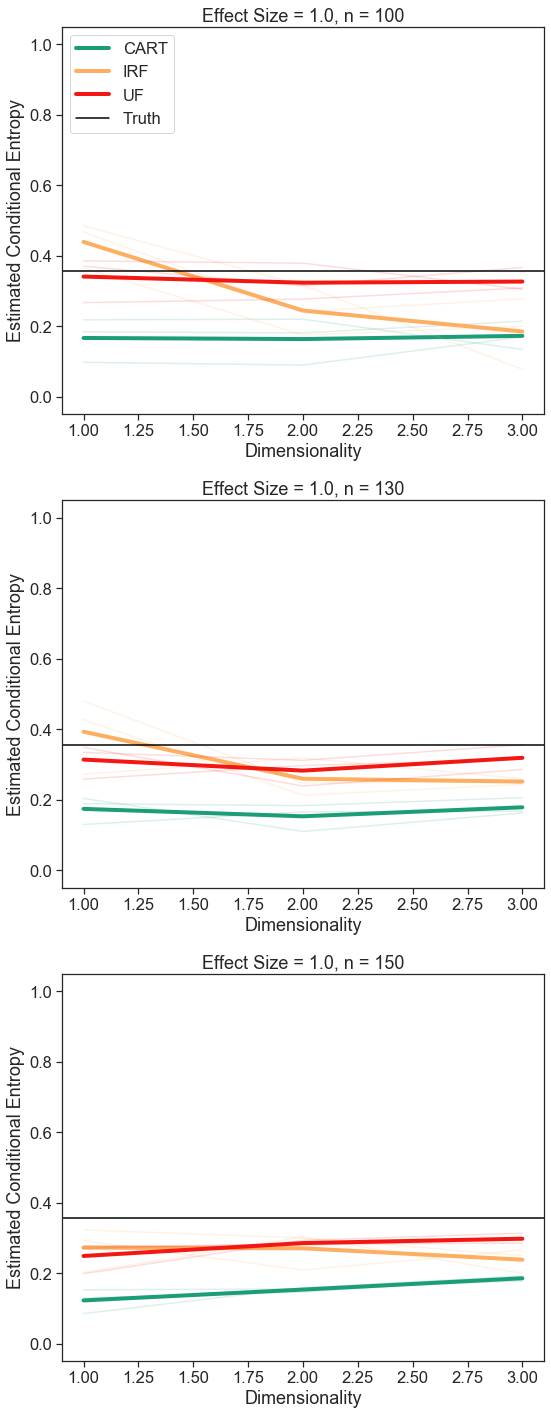

In [17]:
plot_fig7(num_plotted_trials, n0, n1, n2)